In [1]:
!pip install ../input/efficientnet/EfficientNet-PyTorch-master/

Processing /kaggle/input/efficientnet/EfficientNet-PyTorch-master
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=20139 sha256=9c12f5d0b2701bb527e6c63f79249f0dfcbf8d8acf86522ada6f20fba533ab53
  Stored in directory: /root/.cache/pip/wheels/b8/19/b9/77a444bb2bd1e95e7c5e547c97f8f895c711f0a91553122d6d
Successfully built efficientnet-pytorch


In [2]:
!pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ../input/nvidiaapex/.

/opt/conda/lib/python3.7/site-packages/pip/_internal/commands/install.py:243: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
Processing /kaggle/input/nvidiaapex
Skipping wheel build for apex, due to binaries being disabled for it.
    Running setup.py install for apex ... - \ | / - \ | / - \ | / - \ | / - \ | / - done


In [3]:
!rm -rf ./*

In [4]:
import os
import gc
import time
import shutil
import random
import warnings
import typing as tp
from pathlib import Path
from contextlib import contextmanager
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
from glob import glob
from joblib import delayed, Parallel

import cv2
import librosa
import audioread
import soundfile as sf
import librosa.display 

import numpy as np
import pandas as pd

from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

from efficientnet_pytorch import EfficientNet
from apex import amp

In [5]:
class config:
    
    n_mels = 128
    fmin = 20
    fmax = 16000
    period = 5
    image_size = 224
    num_fold = 5
    num_class = 264
    num_workers = 2
    
    ####################
    #training parameters
    ####################
    verbose = True
    verbose_step = 1
    folder = 'effnet'
    use_mixup = True
    use_amp = True
    accumulate_steps = 1
    batch_size = 50
    lr = 3e-4
    n_epochs = 15
    loss_fn = nn.BCEWithLogitsLoss()
    weight_decay = 1e-6
    
    step_scheduler = False
    validation_scheduler = True
    SchedulerClass = torch.optim.lr_scheduler.CosineAnnealingLR
    scheduler_params = dict(
        T_max=n_epochs
    )

In [6]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed()
warnings.filterwarnings("ignore")

In [7]:
ROOT = Path.cwd().parent
INPUT_ROOT = ROOT / "input"
RAW_DATA = INPUT_ROOT / "birdsong-recognition"
TRAIN_AUDIO_DIR = RAW_DATA / "train_audio"
TRAIN_RESAMPLED_AUDIO_DIRS = [
    INPUT_ROOT / "birdsong-resampled-train-audio-{:0>2}".format(i)  for i in range(5)
]
TEST_AUDIO_DIR = RAW_DATA / "test_audio"

train = pd.read_csv(TRAIN_RESAMPLED_AUDIO_DIRS[0] / "train_mod.csv")

if not TEST_AUDIO_DIR.exists():
    TEST_AUDIO_DIR = INPUT_ROOT / "birdcall-check" / "test_audio"
    test = pd.read_csv(INPUT_ROOT / "birdcall-check" / "test.csv")
else:
    test = pd.read_csv(RAW_DATA / "test.csv")

## Split Train/Val DataSet

In [8]:
tmp_list = []
for audio_d in TRAIN_RESAMPLED_AUDIO_DIRS:
    if not audio_d.exists():
        continue
    for ebird_d in audio_d.iterdir():
        if ebird_d.is_file():
            continue
        for wav_f in ebird_d.iterdir():
            tmp_list.append([ebird_d.name, wav_f.name, wav_f.as_posix()])
            
train_wav_path_exist = pd.DataFrame(
    tmp_list, columns=["ebird_code", "resampled_filename", "file_path"])

del tmp_list

train_all = pd.merge(
    train, train_wav_path_exist, on=["ebird_code", "resampled_filename"], how="inner")

print(train.shape)
print(train_wav_path_exist.shape)
print(train_all.shape)

(21375, 38)
(21375, 3)
(21375, 39)


In [9]:
skf = StratifiedKFold(config.num_fold)

train_all["fold"] = -1
for fold_id, (train_index, val_index) in enumerate(skf.split(train_all, train_all["ebird_code"])):
    train_all.iloc[val_index, -1] = fold_id
    
# # check the propotion
fold_proportion = pd.pivot_table(train_all, index="ebird_code", 
                                 columns="fold", values="xc_id", aggfunc=len)
print(fold_proportion.shape)

(264, 5)


In [10]:
use_fold = 2
train_file_list = train_all.query("fold != @use_fold")[["file_path", "ebird_code"]].values.tolist()
val_file_list = train_all.query("fold == @use_fold")[["file_path", "ebird_code"]].values.tolist()

print("[fold {}] train: {}, val: {}".format(use_fold, len(train_file_list), len(val_file_list)))

[fold 2] train: 17100, val: 4275


## Make Labels Dectionary

In [11]:
#https://www.kaggle.com/ttahara/training-birdsong-baseline-resnest50-fast
BIRD_CODE = {
    'aldfly': 0, 'ameavo': 1, 'amebit': 2, 'amecro': 3, 'amegfi': 4,
    'amekes': 5, 'amepip': 6, 'amered': 7, 'amerob': 8, 'amewig': 9,
    'amewoo': 10, 'amtspa': 11, 'annhum': 12, 'astfly': 13, 'baisan': 14,
    'baleag': 15, 'balori': 16, 'banswa': 17, 'barswa': 18, 'bawwar': 19,
    'belkin1': 20, 'belspa2': 21, 'bewwre': 22, 'bkbcuc': 23, 'bkbmag1': 24,
    'bkbwar': 25, 'bkcchi': 26, 'bkchum': 27, 'bkhgro': 28, 'bkpwar': 29,
    'bktspa': 30, 'blkpho': 31, 'blugrb1': 32, 'blujay': 33, 'bnhcow': 34,
    'boboli': 35, 'bongul': 36, 'brdowl': 37, 'brebla': 38, 'brespa': 39,
    'brncre': 40, 'brnthr': 41, 'brthum': 42, 'brwhaw': 43, 'btbwar': 44,
    'btnwar': 45, 'btywar': 46, 'buffle': 47, 'buggna': 48, 'buhvir': 49,
    'bulori': 50, 'bushti': 51, 'buwtea': 52, 'buwwar': 53, 'cacwre': 54,
    'calgul': 55, 'calqua': 56, 'camwar': 57, 'cangoo': 58, 'canwar': 59,
    'canwre': 60, 'carwre': 61, 'casfin': 62, 'caster1': 63, 'casvir': 64,
    'cedwax': 65, 'chispa': 66, 'chiswi': 67, 'chswar': 68, 'chukar': 69,
    'clanut': 70, 'cliswa': 71, 'comgol': 72, 'comgra': 73, 'comloo': 74,
    'commer': 75, 'comnig': 76, 'comrav': 77, 'comred': 78, 'comter': 79,
    'comyel': 80, 'coohaw': 81, 'coshum': 82, 'cowscj1': 83, 'daejun': 84,
    'doccor': 85, 'dowwoo': 86, 'dusfly': 87, 'eargre': 88, 'easblu': 89,
    'easkin': 90, 'easmea': 91, 'easpho': 92, 'eastow': 93, 'eawpew': 94,
    'eucdov': 95, 'eursta': 96, 'evegro': 97, 'fiespa': 98, 'fiscro': 99,
    'foxspa': 100, 'gadwal': 101, 'gcrfin': 102, 'gnttow': 103, 'gnwtea': 104,
    'gockin': 105, 'gocspa': 106, 'goleag': 107, 'grbher3': 108, 'grcfly': 109,
    'greegr': 110, 'greroa': 111, 'greyel': 112, 'grhowl': 113, 'grnher': 114,
    'grtgra': 115, 'grycat': 116, 'gryfly': 117, 'haiwoo': 118, 'hamfly': 119,
    'hergul': 120, 'herthr': 121, 'hoomer': 122, 'hoowar': 123, 'horgre': 124,
    'horlar': 125, 'houfin': 126, 'houspa': 127, 'houwre': 128, 'indbun': 129,
    'juntit1': 130, 'killde': 131, 'labwoo': 132, 'larspa': 133, 'lazbun': 134,
    'leabit': 135, 'leafly': 136, 'leasan': 137, 'lecthr': 138, 'lesgol': 139,
    'lesnig': 140, 'lesyel': 141, 'lewwoo': 142, 'linspa': 143, 'lobcur': 144,
    'lobdow': 145, 'logshr': 146, 'lotduc': 147, 'louwat': 148, 'macwar': 149,
    'magwar': 150, 'mallar3': 151, 'marwre': 152, 'merlin': 153, 'moublu': 154,
    'mouchi': 155, 'moudov': 156, 'norcar': 157, 'norfli': 158, 'norhar2': 159,
    'normoc': 160, 'norpar': 161, 'norpin': 162, 'norsho': 163, 'norwat': 164,
    'nrwswa': 165, 'nutwoo': 166, 'olsfly': 167, 'orcwar': 168, 'osprey': 169,
    'ovenbi1': 170, 'palwar': 171, 'pasfly': 172, 'pecsan': 173, 'perfal': 174,
    'phaino': 175, 'pibgre': 176, 'pilwoo': 177, 'pingro': 178, 'pinjay': 179,
    'pinsis': 180, 'pinwar': 181, 'plsvir': 182, 'prawar': 183, 'purfin': 184,
    'pygnut': 185, 'rebmer': 186, 'rebnut': 187, 'rebsap': 188, 'rebwoo': 189,
    'redcro': 190, 'redhea': 191, 'reevir1': 192, 'renpha': 193, 'reshaw': 194,
    'rethaw': 195, 'rewbla': 196, 'ribgul': 197, 'rinduc': 198, 'robgro': 199,
    'rocpig': 200, 'rocwre': 201, 'rthhum': 202, 'ruckin': 203, 'rudduc': 204,
    'rufgro': 205, 'rufhum': 206, 'rusbla': 207, 'sagspa1': 208, 'sagthr': 209,
    'savspa': 210, 'saypho': 211, 'scatan': 212, 'scoori': 213, 'semplo': 214,
    'semsan': 215, 'sheowl': 216, 'shshaw': 217, 'snobun': 218, 'snogoo': 219,
    'solsan': 220, 'sonspa': 221, 'sora': 222, 'sposan': 223, 'spotow': 224,
    'stejay': 225, 'swahaw': 226, 'swaspa': 227, 'swathr': 228, 'treswa': 229,
    'truswa': 230, 'tuftit': 231, 'tunswa': 232, 'veery': 233, 'vesspa': 234,
    'vigswa': 235, 'warvir': 236, 'wesblu': 237, 'wesgre': 238, 'weskin': 239,
    'wesmea': 240, 'wessan': 241, 'westan': 242, 'wewpew': 243, 'whbnut': 244,
    'whcspa': 245, 'whfibi': 246, 'whtspa': 247, 'whtswi': 248, 'wilfly': 249,
    'wilsni1': 250, 'wiltur': 251, 'winwre3': 252, 'wlswar': 253, 'wooduc': 254,
    'wooscj2': 255, 'woothr': 256, 'y00475': 257, 'yebfly': 258, 'yebsap': 259,
    'yehbla': 260, 'yelwar': 261, 'yerwar': 262, 'yetvir': 263
}

INV_BIRD_CODE = {v: k for k, v in BIRD_CODE.items()}

## Define DataLoader

In [12]:
def spectrogram_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V


def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

def extract_melspectrogram(path, augmentation=True, display=False):

    wave, sr = sf.read(path)
    effective_length = sr * config.period
    if len(wave) < effective_length:
        new_wave = np.zeros(effective_length, dtype=wave.dtype)
        start = np.random.randint(effective_length - len(wave))
        new_wave[start:start + len(wave)] = wave
        wave = new_wave.astype(np.float32)
    elif len(wave) > effective_length:
        start = np.random.randint(len(wave) - effective_length)
        wave = wave[start:start + effective_length].astype(np.float32)
    else:
        wave= wave.astype(np.float32)
    
    #if augmentation:
        #if random.random() < 0.5:
            #wave =  add_white_noise(wave)
    
    melspectrogram = librosa.feature.melspectrogram(wave, sr,
                                                    n_mels=config.n_mels, fmin=config.fmin,
                                                    fmax=config.fmax)
    melspectrogram = librosa.power_to_db(melspectrogram)
    melspectrogram = melspectrogram.astype(np.float32)

    if display:
        librosa.display.specshow(melspectrogram, y_axis='mel', x_axis='time')

    return spectrogram_to_color(melspectrogram)

In [13]:
def time_shift_spectrogram(spectrogram):
    
    
    """ 
    https://github.com/johnmartinsson/bird-species-classification/wiki/Data-Augmentation
    Shift a spectrogram along the time axis in the spectral-domain at random
    """
    nb_cols = spectrogram.shape[1]
    nb_shifts = np.random.randint(0, nb_cols)

    return np.roll(spectrogram, nb_shifts, axis=1)

In [14]:
def pitch_shift_spectrogram(spectrogram):
    """ 
    https://github.com/johnmartinsson/bird-species-classification/wiki/Data-Augmentation
    Shift a spectrogram along the frequency axis in the spectral-domain at random
    """
    nb_cols = spectrogram.shape[0]
    max_shifts = nb_cols//20 # around 5% shift
    nb_shifts = np.random.randint(-max_shifts, max_shifts)

    return np.roll(spectrogram, nb_shifts, axis=0)

In [15]:
def same_class_augmentation(spectrogram, ebrid_code, file_list):
    
    """
    modified from 
    https://github.com/johnmartinsson/bird-species-classification/wiki/Data-Augmentation
    
    """
    
    same_cls_idx = np.where(np.array(file_list)[:, 1] == ebrid_code)[0]
    aug_sig_index = np.random.choice(same_cls_idx, 1, replace=False)[0]
    wav_path, _ = file_list[aug_sig_index]
    image = extract_melspectrogram(wav_path)
    height, width, _ = image.shape
    image = cv2.resize(image, (int(width * config.image_size / height), config.image_size))
    aug_sig= (image / 255.0).astype(np.float32)
    alpha = np.random.rand()
    wave = (1.0-alpha)*spectrogram + alpha*aug_sig
    
    return wave

In [16]:
def freq_mask(spec, F=30, num_masks=1, replace_with_zero=False):
    """
    https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html
    """
    cloned = spec.copy()
    num_mel_channels = cloned.shape[0] #H
    
    for i in range(0, num_masks):        
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): 
            return cloned

        mask_end = random.randrange(f_zero, f_zero + f) 
        if (replace_with_zero): 
            cloned[f_zero:mask_end,:,:] = 0
        else: 
            cloned[f_zero:mask_end,:,:] = cloned.mean()
    
    return cloned

In [17]:
def time_mask(spec, T=40, num_masks=1, replace_with_zero=False):
    
    cloned = spec.copy() #(224, 547, 3)
    len_spectro = cloned.shape[1] #(547)
    
    for i in range(0, num_masks):
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t): 
            return cloned

        mask_end = random.randrange(t_zero, t_zero + t)
        if (replace_with_zero):
            cloned[:,t_zero:mask_end, :] = 0
        else: 
            cloned[:,t_zero:mask_end, :] = cloned.mean()
            
    return cloned

In [18]:
class birddataset(data.Dataset):
    """
    Based On
    https://www.kaggle.com/ttahara/training-birdsong-baseline-resnest50-fast/data?
    """
    
    def __init__(self, file_list, img_size, test=False, augmentation=True, label_smooth=True):
        
        self.file_list = file_list
        self.img_size = img_size
        self.label_smooth = label_smooth
        self.test = test
        self.augmentation = augmentation
 
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx: int):
        
        wav_path, ebird_code = self.file_list[idx]
        image = extract_melspectrogram(wav_path)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = (image / 255.0).astype(np.float32)
        
        if self.augmentation and self.test == False:
            if random.random() < 0.5:
                image = time_shift_spectrogram(image)
            else:
                image = pitch_shift_spectrogram(image)
            
            if random.random() < 0.5:
                image = freq_mask(image, num_masks=2)
            if random.random() < 0.5:
                image = time_mask(image, num_masks=2)
        
        image = torch.from_numpy(image).permute(2, 0, 1) #(C, H, W)
        
        labels = np.zeros(len(BIRD_CODE), dtype="f")
        labels[BIRD_CODE[ebird_code]] = 1
        if self.label_smooth and self.test == False:
            labels = self.make_label_smooth(labels, num_classes=config.num_class)
        
        return image, labels
    
    def make_label_smooth(self, labels, num_classes, epsilon=0.1):
        b = np.ones(num_classes) * (1 / num_classes)
        return (1 - epsilon) * labels + epsilon * b 

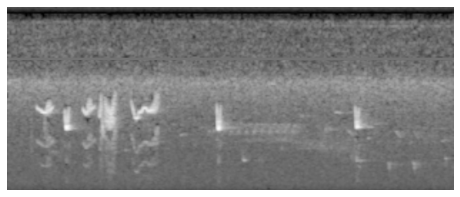

In [19]:
images, labels = birddataset(train_file_list, config.image_size)[14]
sample = images.permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.set_axis_off()
ax.imshow(sample);

## Define Model

In [20]:
!ls ../input/efficientnet-b1-fold1/effnet/last-checkpoint.bin

ls: cannot access '../input/efficientnet-b1-fold1/effnet/last-checkpoint.bin': No such file or directory


In [21]:
def get_model(model_num, weight_path, num_classes, dropout_rate=0.5):
    
    model = EfficientNet.from_name('efficientnet-b{}'.format(model_num))
    model.load_state_dict(torch.load(weight_path))
    in_features = model._fc.in_features
    model._fc = nn.Sequential(nn.Dropout(dropout_rate), nn.Linear(in_features, num_classes))
 
    model.cuda()
    
    return model

## Define Trainer

In [22]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [23]:
class Fitter:
    """
    
    
    
    """
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5
        
        self.model = model
        self.device = device
        self.use_amp = config.use_amp
        self.accumulate_steps = config.accumulate_steps
        self.model.to(self.device)
        self.use_mixup = config.use_mixup
        self.threshold = 0.5
        
        self.loss_fn = config.loss_fn
        self.optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        
        if self.use_amp:
            self.model, self.optimizer = amp.initialize(self.model, self.optimizer, opt_level="O1",verbosity=0)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        
        best_epoch = 0
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss, score = self.validation(self.model, validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, val_score: {score:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step()

            self.epoch += 1
            
            
    def validation(self, model, val_loader):
        model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        pred_results  = []
        origin_labels = []
        
        for step, (images, labels) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = images.to(self.device).float()
                labels = labels.to(self.device).float()
                batch_size = images.shape[0]
                output = self.model(images)
                loss = self.loss_fn(output, labels)
                
                prediction = F.sigmoid(output)
                proba = prediction.detach().cpu().numpy()
                events = proba >= self.threshold
                pred_labels = events.astype(np.int)
                
                pred_results.append(pred_labels)
                origin_labels.append(labels.detach().cpu().numpy())
                
                summary_loss.update(loss.detach().item(), batch_size)
            
        pred_results = np.concatenate(pred_results)    
        origin_labels = np.concatenate(origin_labels)
        score = f1_score(origin_labels, pred_results, average='macro')

        return summary_loss, score

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        self.optimizer.zero_grad() #very important
        for step, (images, labels) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = images.to(self.device).float()
            labels = labels.to(self.device).float()
            batch_size = images.size()[0]
            if self.use_mixup: #using mixup
                mixed_images, y_a, y_b, lam = self.mixup_data(images, labels)
                output = self.model(mixed_images)
                loss = self.mixup_criterion(output, y_a, y_b, lam)
            else:
                output = self.model(images)
                loss = self.loss_fn(output, labels)

            if self.use_amp:
                with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            if (step+1) % self.accumulate_steps == 0: # Wait for several backward steps
                self.optimizer.step()                 # Now we can do an optimizer step
                self.optimizer.zero_grad()

            summary_loss.update(loss.detach().item(), batch_size)

            if self.config.step_scheduler:
                self.scheduler.step()

            
        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({'model_state_dict': self.model.state_dict()}, path)
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')
    

    def mixup_data(self, x, y, alpha=1.0, use_cuda=True):
        """
        https://github.com/facebookresearch/mixup-cifar10/blob/master/train.py
        Returns mixed inputs, pairs of targets, and lambda
        
        """
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1

        batch_size = x.size()[0]
        if use_cuda:
            index = torch.randperm(batch_size).cuda()
        else:
            index = torch.randperm(batch_size)

        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        
        return mixed_x, y_a, y_b, lam
    
    def mixup_criterion(self, pred, y_a, y_b, lam):
        """
        https://github.com/facebookresearch/mixup-cifar10/blob/master/train.py
        """
        return lam * self.loss_fn(pred, y_a) + (1 - lam) * self.loss_fn(pred, y_b)

In [24]:
def run_training(net, config):
    device = torch.device('cuda:0')
    net.to(device)
    
    train_dataset = birddataset(train_file_list, img_size=config.image_size)
    validation_dataset = birddataset(val_file_list, img_size=config.image_size, test=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        pin_memory=False,
        drop_last=True,
        num_workers=config.num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=config.batch_size,
        num_workers=config.num_workers,
        shuffle=False,
        pin_memory=False,
    )

    fitter = Fitter(model=net, device=device, config=config)
    fitter.fit(train_loader, val_loader)

## Start Training

In [25]:
net = get_model(model_num=1, weight_path="../input/efficientnet-pytorch/efficientnet-b1-dbc7070a.pth", num_classes=config.num_class)
run_training(net, config)

Fitter prepared. Device is cuda:0

2020-08-17T09:08:47.800170
LR: 0.0003
[RESULT]: Train. Epoch: 0, summary_loss: 0.01522, time: 451.64534
[RESULT]: Val. Epoch: 0, summary_loss: 0.00745, val_score: 0.69242, time: 92.38702

2020-08-17T09:17:51.957656
LR: 0.0002967221401100708
[RESULT]: Train. Epoch: 1, summary_loss: 0.01521, time: 447.92732
[RESULT]: Val. Epoch: 1, summary_loss: 0.00769, val_score: 0.60581, time: 94.95288

2020-08-17T09:26:54.922100
LR: 0.0002870318186463901
[RESULT]: Train. Epoch: 2, summary_loss: 0.01530, time: 449.36739
[RESULT]: Val. Epoch: 2, summary_loss: 0.00763, val_score: 0.65944, time: 91.70894

2020-08-17T09:35:56.077223
LR: 0.0002713525491562421
[RESULT]: Train. Epoch: 3, summary_loss: 0.01509, time: 438.50236
[RESULT]: Val. Epoch: 3, summary_loss: 0.00786, val_score: 0.62874, time: 90.75749

2020-08-17T09:44:45.418403
LR: 0.00025036959095382875
[RESULT]: Train. Epoch: 4, summary_loss: 0.01518, time: 433.20113
[RESULT]: Val. Epoch: 4, summary_loss: 0.00753, 